In [1]:
# %matplotlib notebook
%matplotlib inline

# %connect_info

import flow.misc
text = """
Jupyter connect hash:
{word}

To connect to current notebook:
    $> jupyter console --existing {filename}
    
"""
print(text.format(word=flow.misc.notebook_word(), filename=flow.misc.notebook_file(flow.misc.notebook_word())))
print("Last run: {}".format(flow.misc.timestamp()))


Jupyter connect hash:
armstrong

To connect to current notebook:
    $> jupyter console --existing kernel-a6c8dce4-12ec-461b-97b8-96cf87092354.json
    

Last run: 2018-10-18-10h06m00s


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import flow

## Is replay rate higher after reminder sessions (9/10/11) than un-reminded (6/8)?

* No, actually lower.
* Seems that the mice take some time to "settle in" after stims are on the screen.

In [33]:
THRESHOLD = 0.1

mice = flow.metadata.MouseSorter.frommeta(tags=['replay1'])

unreminded_events, unreminded_time, unreminded_runs = 0, 0, 0
reminded_events, reminded_time, reminded_runs = 0, 0, 0

In [34]:
for mouse in mice:
    for date in mouse.dates():
        for run in date.runs(runs=[6, 8]):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            lo = t2p.lastonset()
            events = sum(counts['plus'] > lo) + sum(counts['minus'] > lo) + sum(counts['neutral'] > lo)

            n_frames = results.values()[0].shape[0]
            framerate = t2p.framerate

            unreminded_events += events
            unreminded_time += (n_frames - lo) / framerate
            unreminded_runs += 1

        for run in date.runs(runs=[9, 10, 11]):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            lo = t2p.lastonset()
            events = sum(counts['plus'] > lo) + sum(counts['minus'] > lo) + sum(counts['neutral'] > lo)

            n_frames = results.values()[0].shape[0]
            framerate = t2p.framerate

            reminded_events += events
            reminded_time += (n_frames - lo) / framerate
            reminded_runs += 1

In [35]:
print("""
Unreminded ({} runs)
==========
events = {}
time = {}
rate = {}

Reminded ({} runs)
========
events = {}
time = {}
rate = {}
""".format(unreminded_runs, unreminded_events, unreminded_time, unreminded_events/unreminded_time,
           reminded_runs, reminded_events, reminded_time, reminded_events/reminded_time))


Unreminded (48 runs)
events = 1776
time = 86455.7779212
rate = 0.0205422939068

Reminded (268 runs)
events = 5117
time = 463764.686895
rate = 0.0110336128312



## Does replay rate change over time within session?

* Generally goes up within session.
* At a smaller timescale, might be a slight increase at the very beginning of non-reminded trials.

In [6]:
THRESHOLD = 0.1

mice = flow.metadata.MouseSorter.frommeta(tags=['replay1'])
run_nums = [6, 8, 9, 10, 11]

In [7]:
result_list, frames_list = [], []
for mouse in mice:
    for date in mouse.dates():
        for run in date.runs(runs=run_nums):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            
            lo = t2p.lastonset()
            framerate = t2p.framerate
            
            for replay_type in counts:
                c = counts[replay_type]
                c = c[c > lo]
                df = pd.DataFrame({
                    'time': c / framerate,
                    'time_since_last_onset': (c - lo) / framerate,
                    'type': replay_type,
                    'mouse': run.mouse,
                    'date': run.date,
                    'run': run.run})
                result_list.append(df)
                
            frames = np.arange(results.values()[0].shape[0])
            frames_df = pd.DataFrame({
                'time': frames / framerate,
                'time_since_last_onset': (frames - lo) / framerate,
                'mouse': run.mouse,
                'date': run.date,
                'run': run.run})
            frames_list.append(frames_df)
                

result = pd.concat(result_list, ignore_index=True)
frames = pd.concat(frames_list, ignore_index=True)

In [8]:
print(result.shape)
print(result.head())

(6893, 6)
     date mouse  run         time  time_since_last_onset   type
0  160816  AS20    6  1590.510006            1590.510006  minus
1  160818  AS20    6   694.125242             694.125242  minus
2  160818  AS20    6   828.599096             828.599096  minus
3  160818  AS20    6   933.699161             933.699161  minus
4  160818  AS20    6  1543.641059            1543.641059  minus


In [9]:
print(frames.shape)
print(frames.head())

(11295300, 5)
     date mouse  run      time  time_since_last_onset
0  160816  AS20    6  0.000000               0.000000
1  160816  AS20    6  0.064558               0.064558
2  160816  AS20    6  0.129116               0.129116
3  160816  AS20    6  0.193673               0.193673
4  160816  AS20    6  0.258231               0.258231


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


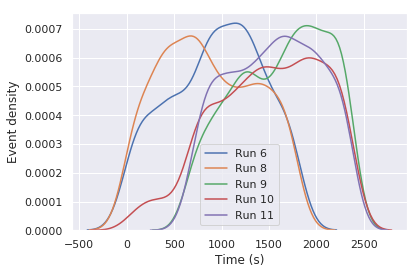

In [10]:
plt.figure()
for run, group in result.groupby('run'):
    sns.kdeplot(group.time, label='Run {}'.format(run), legend=True)
plt.xlabel('Time (s)')
plt.ylabel('Event density');

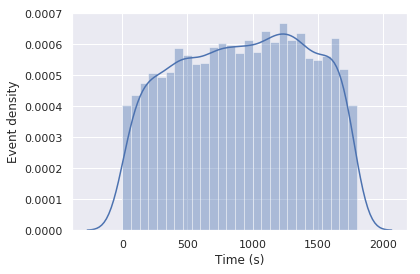

In [46]:
plt.figure()
sns.distplot(
    result.time_since_last_onset, hist=True, kde=True,
    hist_kws={'range': (0, 1800)}, kde_kws={'clip': (0, 1800)})
plt.xlabel('Time (s)')
plt.ylabel('Event density');

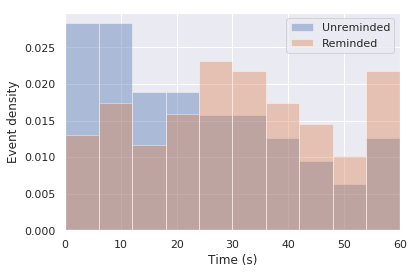

In [23]:
plt.figure()
sns.distplot(result.loc[result.run.isin([6, 8]), 'time_since_last_onset'],
             label='Unreminded', hist=True, kde=False, bins=10, hist_kws={'range': (0, 60)},
             norm_hist=True)
sns.distplot(result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'],
             label='Reminded', hist=True, kde=False, bins=10, hist_kws={'range': (0, 60)},
             norm_hist=True)
plt.legend()
plt.xlim(0, 60)
plt.xlabel('Time (s)')
plt.ylabel('Event density');

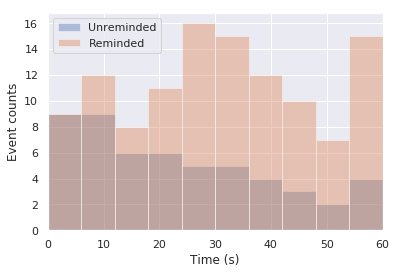

In [24]:
plt.figure()
sns.distplot(result.loc[result.run.isin([6, 8]), 'time_since_last_onset'],
             label='Unreminded', hist=True, kde=False, bins=10, hist_kws={'range': (0, 60)},
             norm_hist=False)
sns.distplot(result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'],
             label='Reminded', hist=True, kde=False, bins=10, hist_kws={'range': (0, 60)},
             norm_hist=False)
plt.legend()
plt.xlim(0, 60)
plt.xlabel('Time (s)')
plt.ylabel('Event counts');

### Neither of these normalizations is quite right, since there are different numbers of runs between groups.

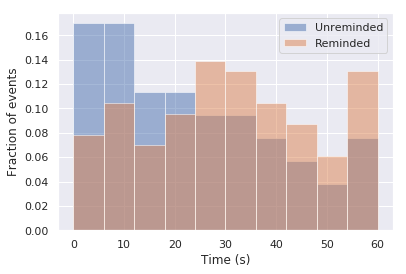

In [25]:
plt.figure()

counts, edges, patches = plt.hist(result.loc[result.run.isin([6, 8]), 'time_since_last_onset'],
                                  bins=10, range=(0, 60), alpha=0.5, label='Unreminded')
n_events = float(sum(counts))
for patch in patches:
    patch.set_height(patch.get_height() / n_events)
    
counts, edges, patches = plt.hist(result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'],
                                  bins=10, range=(0, 60), alpha=0.5, label='Reminded')
n_events = float(sum(counts))
for patch in patches:
    patch.set_height(patch.get_height() / n_events)

ax = plt.gca()
ax.relim()
ax.autoscale_view()

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Fraction of events');

### Still wrong. Need to normalize to total amount of time imaged from 0-60.

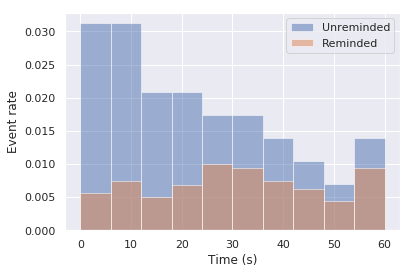

In [28]:
plt.figure()
framerate = 15.49

counts, edges, patches = plt.hist(result.loc[result.run.isin([6, 8]), 'time_since_last_onset'],
                                  bins=10, range=(0, 60), alpha=0.5, label='Unreminded')
run_frames = frames[frames.run.isin([6, 8])]
for idx, patch in enumerate(patches):
    n_frames = run_frames[(run_frames.time_since_last_onset >= edges[idx]) &
                          (run_frames.time_since_last_onset < edges[idx+1])].shape[0]
    patch.set_height(patch.get_height() / (n_frames / framerate))
    
counts, edges, patches = plt.hist(result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'],
                                  bins=10, range=(0, 60), alpha=0.5, label='Reminded')
run_frames = frames[frames.run.isin([9, 10, 11])]
for idx, patch in enumerate(patches):
    n_frames = run_frames[(run_frames.time_since_last_onset >= edges[idx]) &
                          (run_frames.time_since_last_onset < edges[idx+1])].shape[0]
    patch.set_height(patch.get_height() / (n_frames / framerate))

ax = plt.gca()
ax.relim()
ax.autoscale_view()

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Event rate');

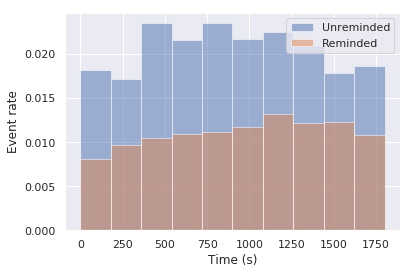

In [32]:
plt.figure()
framerate = 15.49

counts, edges, patches = plt.hist(result.loc[result.run.isin([6, 8]), 'time_since_last_onset'],
                                  bins=10, range=(0, 1800), alpha=0.5, label='Unreminded')
run_frames = frames[frames.run.isin([6, 8])]
for idx, patch in enumerate(patches):
    n_frames = run_frames[(run_frames.time_since_last_onset >= edges[idx]) &
                          (run_frames.time_since_last_onset < edges[idx+1])].shape[0]
    patch.set_height(patch.get_height() / (n_frames / framerate))
    
counts, edges, patches = plt.hist(result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'],
                                  bins=10, range=(0, 1800), alpha=0.5, label='Reminded')
run_frames = frames[frames.run.isin([9, 10, 11])]
for idx, patch in enumerate(patches):
    n_frames = run_frames[(run_frames.time_since_last_onset >= edges[idx]) &
                          (run_frames.time_since_last_onset < edges[idx+1])].shape[0]
    patch.set_height(patch.get_height() / (n_frames / framerate))

ax = plt.gca()
ax.relim()
ax.autoscale_view()

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Event rate');

### Try with a shorter last onset buffer

In [40]:
THRESHOLD = 0.1

mice = flow.metadata.MouseSorter.frommeta(tags=['replay1'])
run_nums = [6, 8, 9, 10, 11]

In [41]:
result_list, frames_list = [], []
for mouse in mice:
    for date in mouse.dates():
        for run in date.runs(runs=run_nums):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            
            lo = t2p.lastonset(2)
            framerate = t2p.framerate
            
            for replay_type in counts:
                c = counts[replay_type]
                c = c[c > lo]
                df = pd.DataFrame({
                    'time': c / framerate,
                    'time_since_last_onset': (c - lo) / framerate,
                    'type': replay_type,
                    'mouse': run.mouse,
                    'date': run.date,
                    'run': run.run})
                result_list.append(df)
                
            frames = np.arange(results.values()[0].shape[0])
            frames_df = pd.DataFrame({
                'time': frames / framerate,
                'time_since_last_onset': (frames - lo) / framerate,
                'mouse': run.mouse,
                'date': run.date,
                'run': run.run})
            frames_list.append(frames_df)
                

result = pd.concat(result_list, ignore_index=True)
frames = pd.concat(frames_list, ignore_index=True)

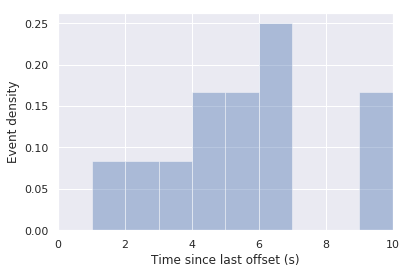

In [44]:
plt.figure()
sns.distplot(
    result.loc[result.run.isin([9, 10, 11]), 'time_since_last_onset'], hist=True, kde=False, bins=10, norm_hist=True,
    hist_kws={'range': (0, 10)})

plt.xlim(0, 10)
plt.xlabel('Time since last offset (s)')
plt.ylabel('Event density');